# Set-up

The goal of this script is to conduct feature selection. We wish to select features that will be used for machine learning. We may consider using **two** sets of features: One which considers multicollinearity and one that doesn't. These two feature sets can be used for machine learning algorithms that are and are not affected by multicollinearity, respectively.

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white' # Since I use a dark IDE

# To allow multiple outputs per cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
wba_data = pd.read_csv('wba_data_CLEAN.csv')

# Removing generated index column and subject column
wba_data = wba_data.drop(["Unnamed: 0", "Subject"], axis=1)

wba_data.head()

,Gender,AgeY,PTA0.5,PTA1,PTA2,PTA4,PTAAv4FA,ECV,TPP,SC,...,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,0,9.333333,20,20,20,20,20,1.08,-189.0,0.52,...,-0.405697,-2.841202,1.594642,0.724436,-0.579289,-0.553364,0.704006,-0.409157,0.072477,-0.217327
1,0,9.500000,20,20,20,20,20,1.28,-49.0,1.28,...,1.479339,1.668937,-0.048483,0.608993,0.251156,-0.710949,0.604375,-0.616950,0.637559,-0.469144
2,1,9.833333,20,20,20,20,20,1.26,-27.0,0.87,...,-0.343253,-0.215469,-0.777275,-1.703650,0.510768,-0.413348,-0.206985,-0.375959,0.339409,-0.049631
3,0,9.916667,20,20,20,20,20,0.64,-8.0,0.60,...,-0.603940,1.065511,1.333238,0.796636,0.454654,-0.116502,0.247162,0.303749,-0.243954,-0.046242
4,0,7.916667,20,20,20,20,20,0.92,-17.0,1.65,...,-0.434886,2.172756,0.895713,1.079165,1.445886,0.345314,-1.758196,0.268712,-0.148645,-0.204201


Creating list of features to be analysed

In [4]:
features = list(wba_data.columns)

Removing PCs:

In [5]:
for feature in wba_data.columns:
    if feature[:2] == "PC":
        print("Removing {}".format(feature))
        features.remove(feature)

# features

Removing PC1
Removing PC2
Removing PC3
Removing PC4
Removing PC5
Removing PC6
Removing PC7
Removing PC8
Removing PC9
Removing PC10
Removing PC11
Removing PC12
Removing PC13
Removing PC14
Removing PC15


## Train Test Split

In [6]:
wba_data[wba_data.columns[:20]]

,Gender,AgeY,PTA0.5,PTA1,PTA2,PTA4,PTAAv4FA,ECV,TPP,SC,TympType,OAE1,OAE1.4,OAE2,OAE2.8,OAE4,OverallPoF,Ear coded,Pressure,f(226.0000)
0,0,9.333333,20,20,20,20,20,1.08,-189.0,0.52,1,3.0,10.0,18.0,14.0,8.0,1,0,-1,0.0987
1,0,9.500000,20,20,20,20,20,1.28,-49.0,1.28,0,7.0,4.0,9.0,5.0,6.0,0,0,-4,0.1114
2,1,9.833333,20,20,20,20,20,1.26,-27.0,0.87,0,9.0,12.0,8.0,12.0,16.0,0,0,-4,0.1096
3,0,9.916667,20,20,20,20,20,0.64,-8.0,0.60,0,13.0,9.0,13.0,11.0,12.0,0,0,2,0.0748
4,0,7.916667,20,20,20,20,20,0.92,-17.0,1.65,0,7.0,0.0,2.0,12.0,6.0,1,0,-2,0.1863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,1,8.666667,20,20,20,20,20,1.18,-48.0,1.07,0,10.3,18.6,12.0,0.5,3.7,0,1,1,0.0663
235,0,8.666667,20,20,20,20,20,0.78,-17.0,0.77,0,13.2,23.5,17.3,14.3,6.7,0,1,-4,0.0688
236,1,8.833333,20,20,20,20,20,0.90,2.0,1.02,0,5.3,11.0,15.3,14.6,11.5,0,1,-5,0.1016
237,1,8.250000,20,20,20,20,20,0.76,-173.0,0.15,1,-3.6,-0.9,-2.4,3.0,3.0,1,1,-5,0.0366


Making list of all frequencies for the cases where we only want to look at frequencies

In [7]:
freqs = [f for f in features if f[:2] == "f("]

Making list of all independent/control variables

In [8]:
predictors = [f for f in features if f != 'OverallPoF']

In [9]:
# Dependent variable
y = wba_data['OverallPoF']

# Independent and control variables
X = wba_data[predictors]

X.columns

Index(['Gender', 'AgeY', 'PTA0.5', 'PTA1', 'PTA2', 'PTA4', 'PTAAv4FA', 'ECV',
       'TPP', 'SC',
       ...
       'f(6168.8433)', 'f(6349.6042)', 'f(6535.6618)', 'f(6727.1713)',
       'f(6924.2925)', 'f(7127.1897)', 'f(7336.0323)', 'f(7550.9945)',
       'f(7772.2555)', 'f(8000.0000)'],
      dtype='object', length=125)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Feature Selection


Creating dataframe with only frequencies and label column (just in case)

In [11]:
wba_data_freqsonly = wba_data[freqs+["OverallPoF"]]

## Feature Assessment Functions

Creating function to visualise which frequencies are selected for each technique

In [12]:
def assess_freqs(wba_data, freq_cols, selected, title = "Selected Frequencies"):
    """
    wba_data: Full dataset
    freq_cols: List of all frequency column names
    selected: List of selected frequencies
    """

    # Creating melted dataframe (long format) for plotting
    overall_pof_df = wba_data[['OverallPoF'] + freq_cols]
    overall_pof_df = overall_pof_df.replace({'OverallPoF':{0: 'Pass', 1: 'Fail'}})
    overall_pof_df = overall_pof_df.groupby('OverallPoF').mean()
    overall_pof_df = overall_pof_df.melt(ignore_index=False)
    overall_pof_df = overall_pof_df.reset_index()

    # Plotting
    ax = sns.pointplot(x='variable', y='value', hue='OverallPoF', data=overall_pof_df)

    # Adding vertical lines at selected frequencies
    position = 0
    for freq in freq_cols:
        if freq in selected:
            ax.axvline(x=position, ls='--', color='red')
        position += 1

    sns.set(rc={'figure.figsize':(20,10)})

    # Rotate x-axis labels
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

    ax.set(title = title)

    # Show only every 2 tick labels on x-axis
    # plt.setp(ax.get_xticklabels()[::2], visible=False)

    plt.tight_layout()
    plt.show();



Correlation Assessment

In [13]:
def assess_corrs(df, cols, annot=False):
    """
    Creates correlation heatmap columns `cols` in dataframe `df`
    """
    corr_matrix_pca = df[cols].corr()

    sns.set(rc={'figure.figsize':(20,15)})
    sns.heatmap(corr_matrix_pca, annot=annot)

Control variables and frequencies assessment

In [14]:
def assess_feats(features):
    """
    Takes list of selected features and separates control variables and frequencies
    """
    conts = [f for f in features if f[:2] != "f("]
    freqs = [f for f in features if f[:2] == "f("]

    print("Selected control variables:\n{}".format(conts))
    print("Selected frequencies:\n{}".format(freqs))
    return conts, freqs



Example usage:

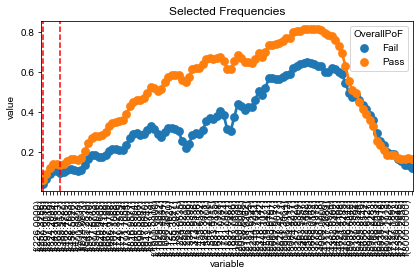

In [15]:
assess_freqs(wba_data, freqs, ['f(343.4884)', 'f(226.0000)'])

## Filter Methods

### Information gain

<AxesSubplot:>

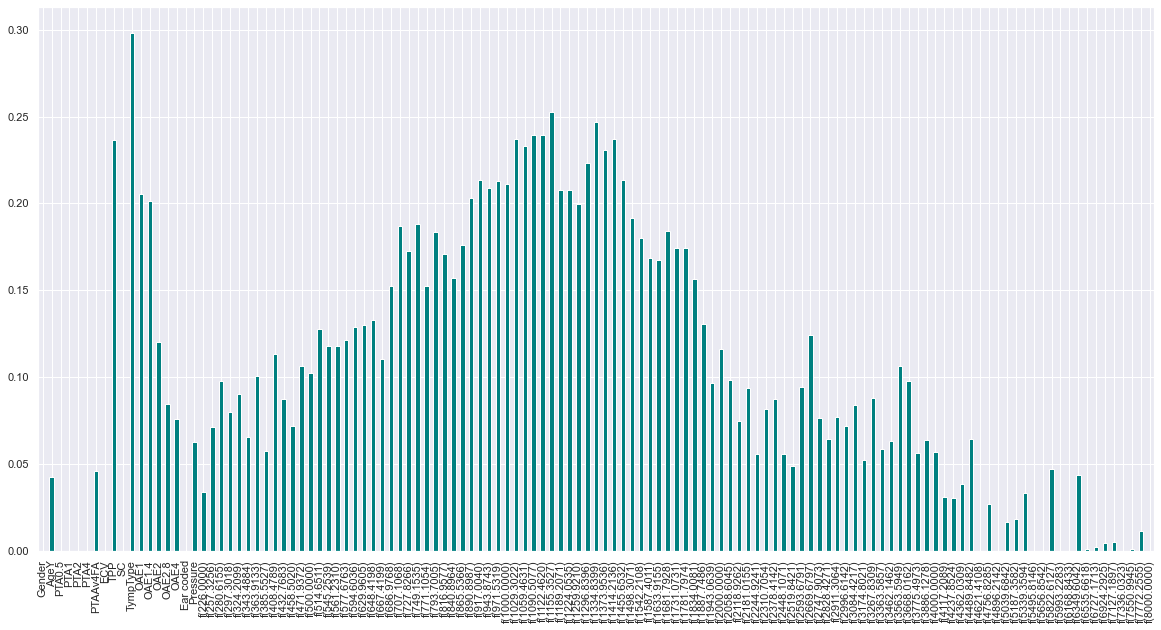

In [16]:
from sklearn.feature_selection import mutual_info_classif
from matplotlib.pyplot import figure

importances = mutual_info_classif(X, y)
feat_importances = pd.Series(importances, X.columns[0:len(X.columns)])
feat_importances.plot(kind='bar', color='teal')

plt.rcParams["figure.figsize"] = (40,10)
plt.show()


## Correlation Coefficient

In [28]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]

    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()

    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]

    return cor_support, cor_feature

cor_support, features_cor = cor_selector(X, y, num_feats=24)

print(str(len(features_cor)), 'selected features')

24 selected features


/Applications/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Applications/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [29]:
conts_cor, freqs_cor = assess_feats(features_cor)

Selected control variables:
['TPP', 'TympType']
Selected frequencies:
['f(1887.7486)', 'f(1029.3022)', 'f(1059.4631)', 'f(1834.0081)', 'f(1090.5077)', 'f(1781.7974)', 'f(1731.0731)', 'f(1122.4620)', 'f(1681.7928)', 'f(1155.3527)', 'f(1189.2071)', 'f(1633.9155)', 'f(1224.0535)', 'f(1587.4011)', 'f(1259.9210)', 'f(1542.2108)', 'f(1498.3071)', 'f(1296.8396)', 'f(1455.6532)', 'f(1373.9536)', 'f(1334.8399)', 'f(1414.2136)']


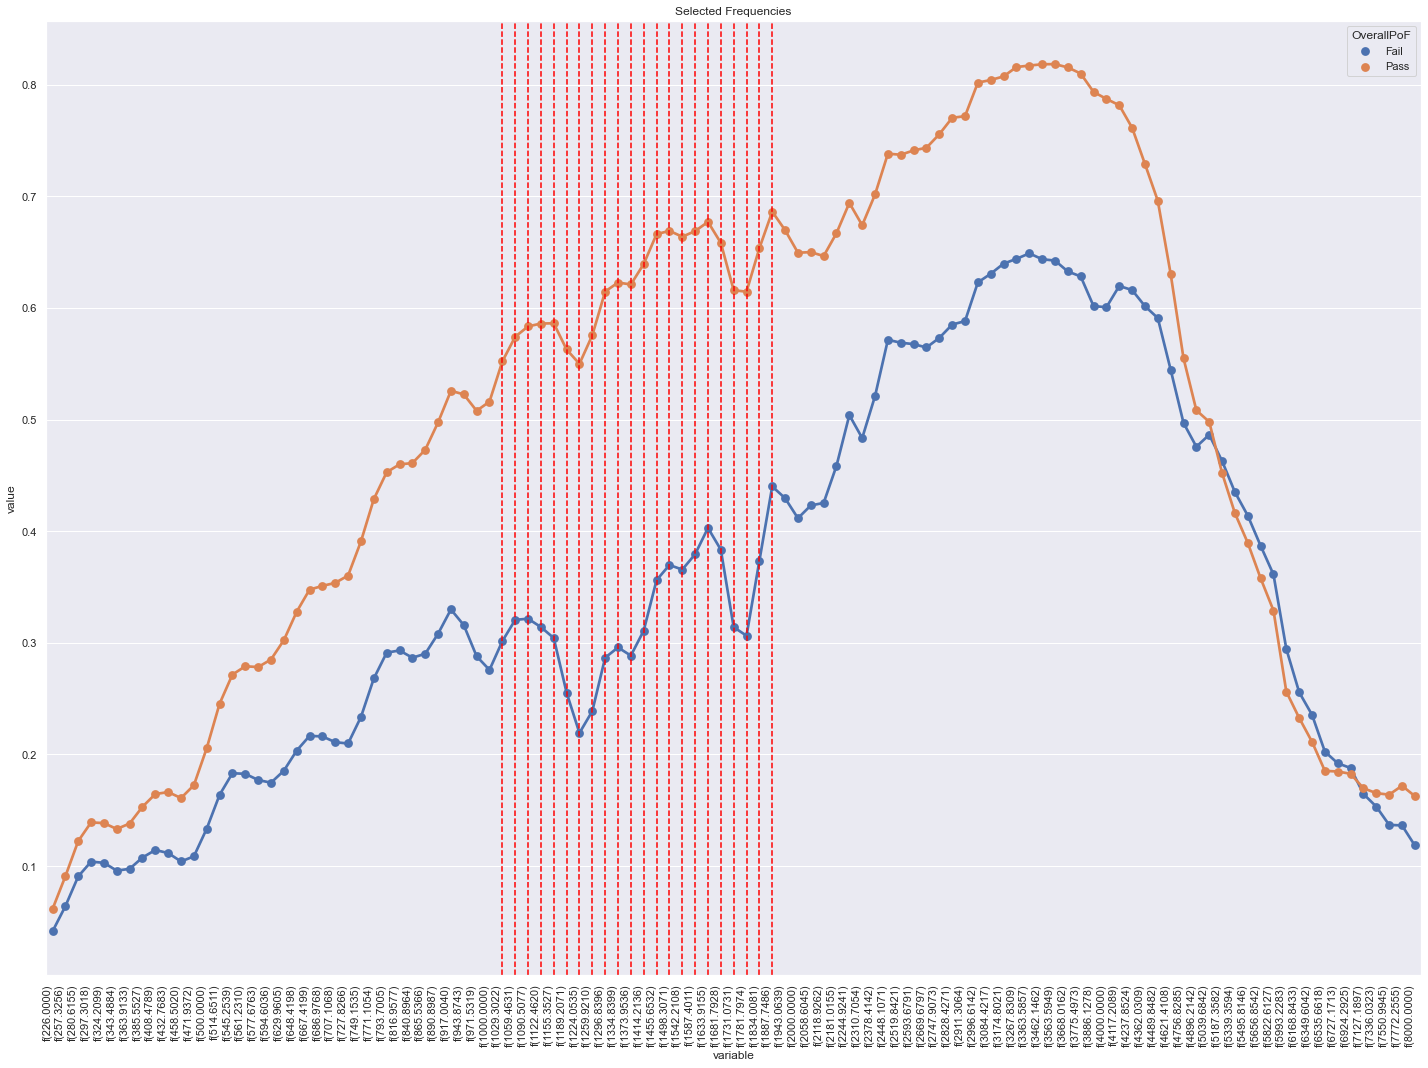

In [30]:
assess_freqs(wba_data, freqs, freqs_cor)

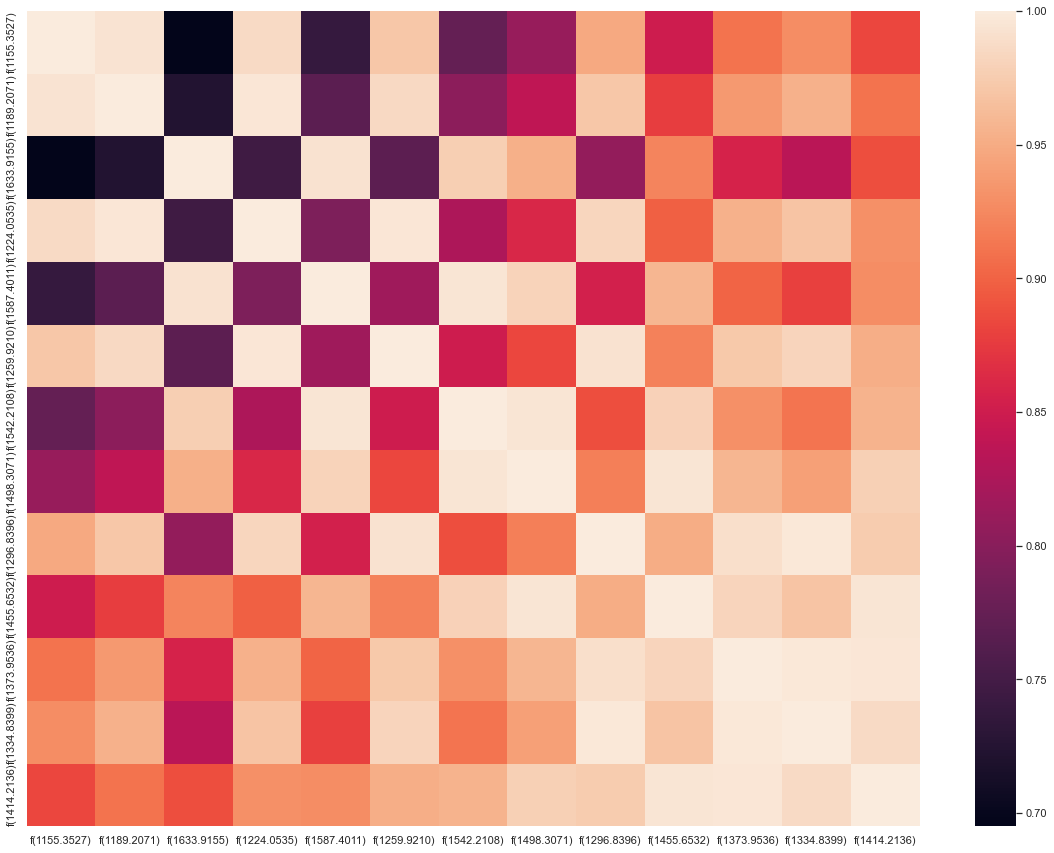

In [27]:
assess_corrs(wba_data, freqs_cor)

In [118]:
cor = wba_data_freqsonly.corr()

corr_threshold = 0.5

# Correlation with predicted variable (deep copy as we will be editing `cor`)
cor_y = pd.DataFrame(cor['OverallPoF'].copy(deep=True))
cor_y['freq'] = cor_y.index

cor_y = cor_y.reset_index(level=0)

# cor_y = y.drop(columns=['index'])

cor_y_list = list(zip(cor_y.OverallPoF, cor_y.freq))

cor_y_sorted = sorted(cor_y_list, key = lambda x: abs(x[0]), reverse=True)

# Deep copy to iterate through
cor_y_sorted_all = cor_y_sorted[:]
freqs_cor = freqs[:]

removed_freqs = []

# Remove those highly correlated
for freq in cor_y_sorted_all:
    freq = freq[1]

    if freq in removed_freqs:
        continue
    
    high_cor_freqs = cor.loc[cor[freq] > 0.95].index

    for freq in high_cor_freqs:
        try:
            freqs_cor.remove(freq)
            removed_freqs.append(freq)
        except Exception:
            pass

print(len(freqs))
print(len(freqs_cor))
    

107
0


In [102]:
cor.describe()

,f(226.0000),f(257.3256),f(280.6155),f(297.3018),f(324.2099),f(343.4884),f(363.9133),f(385.5527),f(408.4789),f(432.7683),...,f(6349.6042),f(6535.6618),f(6727.1713),f(6924.2925),f(7127.1897),f(7336.0323),f(7550.9945),f(7772.2555),f(8000.0000),OverallPoF
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,...,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.205181,0.244048,0.267253,0.290959,0.306509,0.320378,0.337264,0.346978,0.343120,0.353073,...,0.103508,0.111678,0.111311,0.108096,0.123004,0.135665,0.147790,0.151301,0.153220,-0.337439
std,0.305139,0.335446,0.355333,0.359324,0.358410,0.349044,0.354902,0.369562,0.377222,0.382503,...,0.381671,0.373015,0.368798,0.364442,0.352392,0.335884,0.314590,0.296812,0.266795,0.240279
min,-0.169571,-0.170009,-0.192371,-0.208013,-0.210525,-0.218172,-0.237659,-0.257771,-0.266598,-0.277186,...,-0.318571,-0.320768,-0.333994,-0.328791,-0.305887,-0.271200,-0.245624,-0.216809,-0.172711,-0.620138
25%,-0.039345,-0.041176,-0.041115,-0.027934,-0.020024,-0.005902,0.006140,-0.001254,-0.014238,-0.002829,...,-0.141188,-0.117908,-0.112912,-0.111867,-0.092049,-0.069960,-0.066768,-0.062311,-0.027830,-0.514986
50%,0.156807,0.170608,0.195478,0.220587,0.241510,0.256453,0.270461,0.257730,0.258295,0.253896,...,-0.029657,-0.022928,-0.023008,-0.020158,-0.001648,0.023905,0.061704,0.069566,0.078277,-0.375271
75%,0.337965,0.437724,0.500354,0.542906,0.563590,0.578850,0.618045,0.666108,0.683948,0.706747,...,0.143201,0.172096,0.179151,0.171708,0.192086,0.209956,0.235117,0.241253,0.236243,-0.216261
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [88]:
cor.loc[cor['f(226.0000)'] > 0.9].index

# cor[cor['f(226.0000)'] > 0.5

Index(['f(226.0000)', 'f(257.3256)', 'f(280.6155)', 'f(297.3018)',
       'f(324.2099)'],
      dtype='object')

In [112]:
cor

,f(226.0000),f(257.3256),f(280.6155),f(297.3018),f(324.2099),f(343.4884),f(363.9133),f(385.5527),f(408.4789),f(432.7683),...,f(6349.6042),f(6535.6618),f(6727.1713),f(6924.2925),f(7127.1897),f(7336.0323),f(7550.9945),f(7772.2555),f(8000.0000),OverallPoF
f(226.0000),1.000000,0.976836,0.939931,0.921035,0.908369,0.877769,0.837697,0.775316,0.727198,0.727595,...,0.101696,0.131410,0.167088,0.161552,0.176344,0.167332,0.184830,0.176638,0.162486,-0.127494
f(257.3256),0.976836,1.000000,0.984046,0.962804,0.940899,0.903632,0.878598,0.855017,0.832302,0.837138,...,0.063389,0.100020,0.140092,0.146433,0.166653,0.168942,0.186340,0.186586,0.174387,-0.170009
f(280.6155),0.939931,0.984046,1.000000,0.978722,0.959261,0.917306,0.908551,0.904438,0.892310,0.890141,...,0.052660,0.093576,0.137322,0.148937,0.173758,0.182788,0.203168,0.207778,0.196859,-0.192371
f(297.3018),0.921035,0.962804,0.978722,1.000000,0.981452,0.952990,0.931212,0.901522,0.877282,0.904351,...,0.101160,0.140460,0.181316,0.186792,0.211955,0.219008,0.244568,0.244255,0.233564,-0.208013
f(324.2099),0.908369,0.940899,0.959261,0.981452,1.000000,0.990305,0.976281,0.937695,0.895974,0.902005,...,0.134085,0.171713,0.209527,0.208949,0.236227,0.242831,0.274834,0.271452,0.261909,-0.210525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f(7336.0323),0.167332,0.168942,0.182788,0.219008,0.242831,0.254745,0.248751,0.213516,0.177474,0.180369,...,0.873370,0.911100,0.935545,0.962405,0.987869,1.000000,0.980220,0.957404,0.897785,-0.028675
f(7550.9945),0.184830,0.186340,0.203168,0.244568,0.274834,0.288786,0.280056,0.239989,0.199235,0.202014,...,0.800413,0.844645,0.876165,0.903815,0.948645,0.980220,1.000000,0.990162,0.957553,-0.062628
f(7772.2555),0.176638,0.186586,0.207778,0.244255,0.271452,0.283432,0.280780,0.250901,0.215884,0.215366,...,0.741516,0.787312,0.822599,0.859668,0.911681,0.957404,0.990162,1.000000,0.981025,-0.080325
f(8000.0000),0.162486,0.174387,0.196859,0.233564,0.261909,0.274531,0.272450,0.245087,0.211237,0.210278,...,0.649982,0.696211,0.727945,0.766607,0.833556,0.897785,0.957553,0.981025,1.000000,-0.096428


### Variance Threshold

In [268]:
from sklearn.feature_selection import VarianceThreshold

v_threshold = VarianceThreshold(threshold=0.03)
v_threshold.fit(X)
v_threshold.get_support()

VarianceThreshold(threshold=0.03)

array([ True,  True, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False])

### PCA Correlation

For this feature selection method, we conduct PCA to preserve `X`% variance. For each PCA, we select the frequency that has the highest absolute correlation to it.

In [175]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(wba_data_freqsonly)

freqs_std = scaler.transform(wba_data_freqsonly)

StandardScaler()

In [177]:
from sklearn.decomposition import PCA
import seaborn as sns
from bioinfokit.visuz import cluster

def wba_pca(var_preserve, freqs_std):
    """
    var_preserve: amount of variance you wish to preserve (decimal)
    freqs_std: scaled (standardised) frequencies (dataframe)
    Returns principal components (numpy array), number of components (int), PCA object
    """
    pca = PCA(n_components = var_preserve)

    components = pca.fit_transform(freqs_std)

    n_components = components.shape[1]

    print("Preserving {0}% variance...".format(var_preserve*100))
    print("107 frequencies reduced to {0} components.".format(n_components))

    return components, n_components, pca

components, n_components, pca = wba_pca(var_preserve = 0.95, freqs_std=freqs_std)

Preserving 95.0% variance...
107 frequencies reduced to 8 components.


In [126]:
pc_list = ["PC"+str(i) for i in list(range(1, n_components+1))]
print([p for p in pc_list])

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16']


In [127]:
pca_df = pd.DataFrame(components, columns = pc_list)
pca_df = pd.concat([wba_data_freqsonly, pca_df], axis=1)

In [172]:
pca_cor_df = pca_df.corr()[pc_list]
pca_cor_df['freq'] = pca_cor_df.index

pca_cor_df = pca_cor_df.loc[pca_cor_df['freq'].isin(freqs), ]

# pca_cor_df
freqs_pca = []

for pc in pc_list:
    max_cor = max(abs(pca_cor_df[pc]))
    max_freq = pca_cor_df.loc[abs(pca_cor_df[pc]) == max_cor, ['freq']]
    max_freq = max_freq['freq'].to_string(index=False)
    freqs_pca.append(max_freq)

print(freqs_pca)

['f(971.5319)', 'f(3462.1462)', 'f(6168.8433)', 'f(226.0000)', 'f(8000.0000)', 'f(2593.6791)', 'f(226.0000)', 'f(8000.0000)', 'f(8000.0000)', 'f(226.0000)', 'f(8000.0000)', 'f(1122.4620)', 'f(8000.0000)', 'f(2669.6797)', 'f(8000.0000)', 'f(343.4884)']


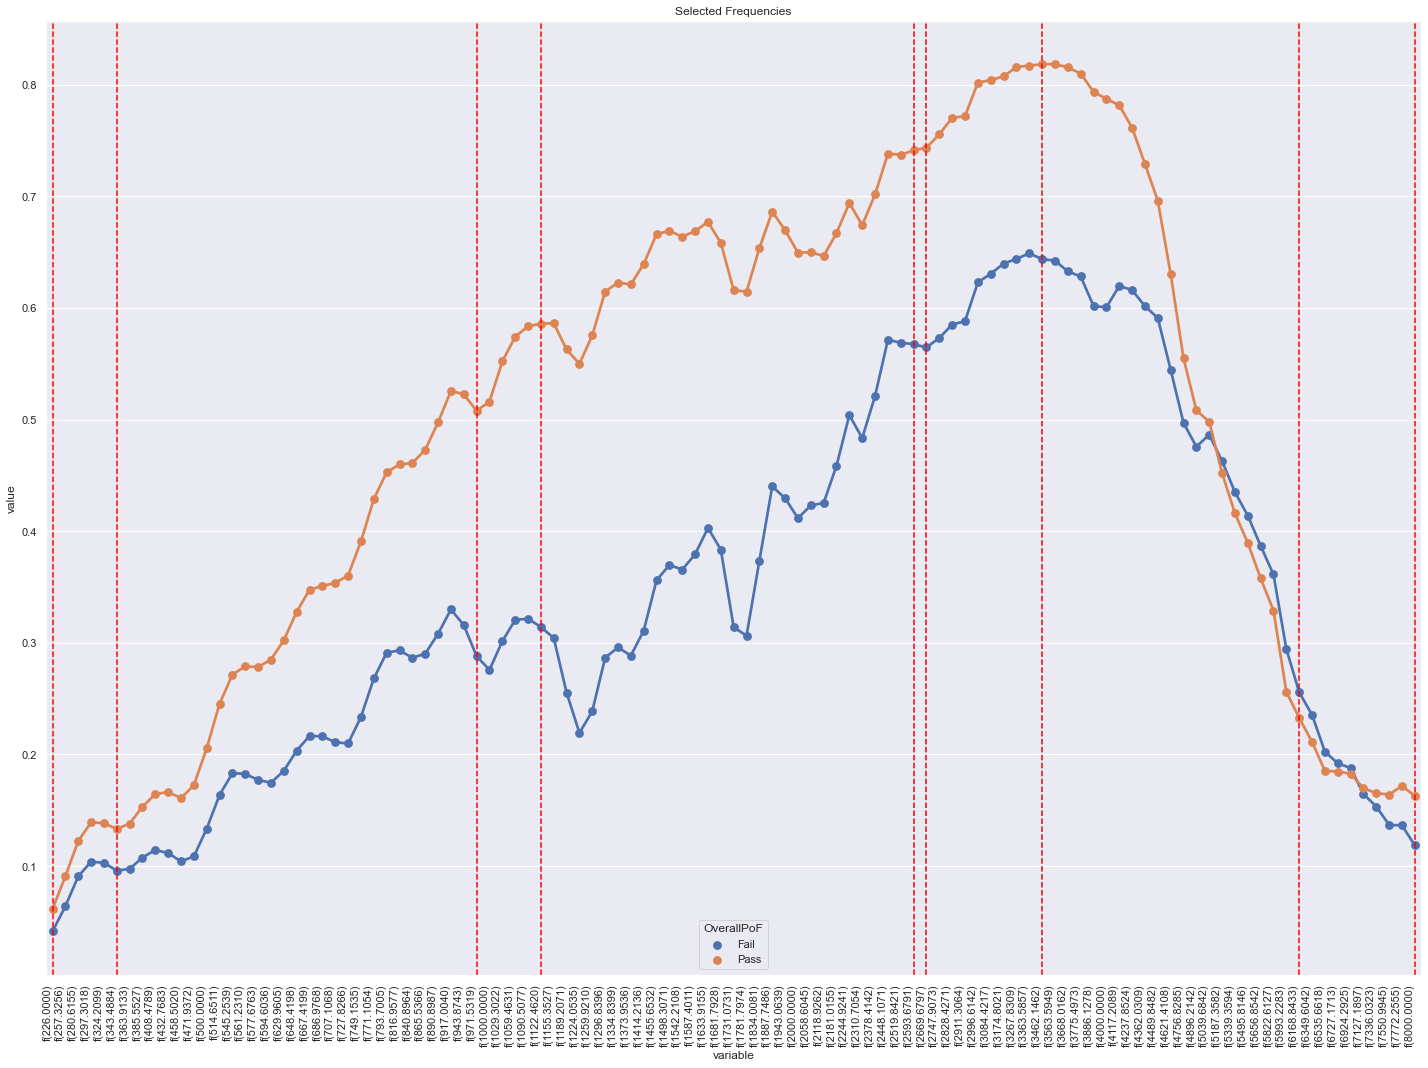

In [174]:
assess_freqs(wba_data, freqs, freqs_pca)

## Wrapper Methods

Methods that seach all possible feature subsets and assess their quality

### Forward Feature Selection

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    class_weight = "balanced",
    solver = "lbfgs",
    random_state=42,
    n_jobs = -1
)

ffs = SequentialFeatureSelector(lr, k_features = 'best', forward = True, n_jobs = -1)
ffs.fit(X, y)

In [271]:
features_ffs = list(ffs.k_feature_names_)
conts_ffs, freqs_ffs = assess_feats(features_ffs)

Selected control variables:
['Gender', 'AgeY', 'PTA0.5', 'PTA1', 'PTA2', 'PTA4', 'PTAAv4FA', 'ECV', 'TympType', 'OAE2.8']
Selected frequencies:
['f(226.0000)', 'f(257.3256)', 'f(280.6155)', 'f(297.3018)', 'f(324.2099)', 'f(343.4884)', 'f(363.9133)', 'f(385.5527)', 'f(408.4789)', 'f(432.7683)', 'f(458.5020)', 'f(471.9372)', 'f(500.0000)', 'f(514.6511)', 'f(545.2539)', 'f(561.2310)', 'f(577.6763)', 'f(594.6036)', 'f(629.9605)', 'f(648.4198)', 'f(667.4199)', 'f(686.9768)', 'f(840.8964)', 'f(1029.3022)', 'f(1059.4631)', 'f(1224.0535)', 'f(1498.3071)', 'f(2058.6045)', 'f(2911.3064)', 'f(5993.2283)', 'f(8000.0000)']


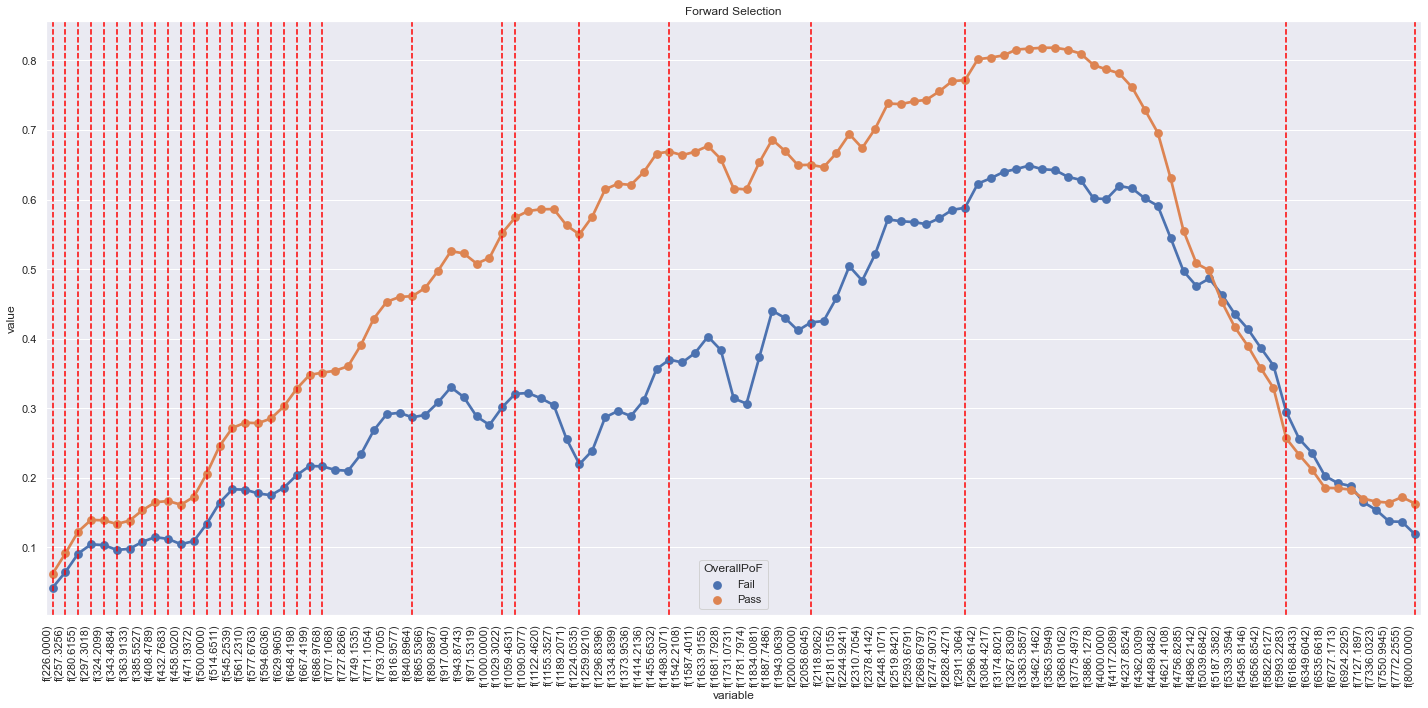

In [273]:
assess_freqs(wba_data, freqs, features_ffs, title="Forward Selection")

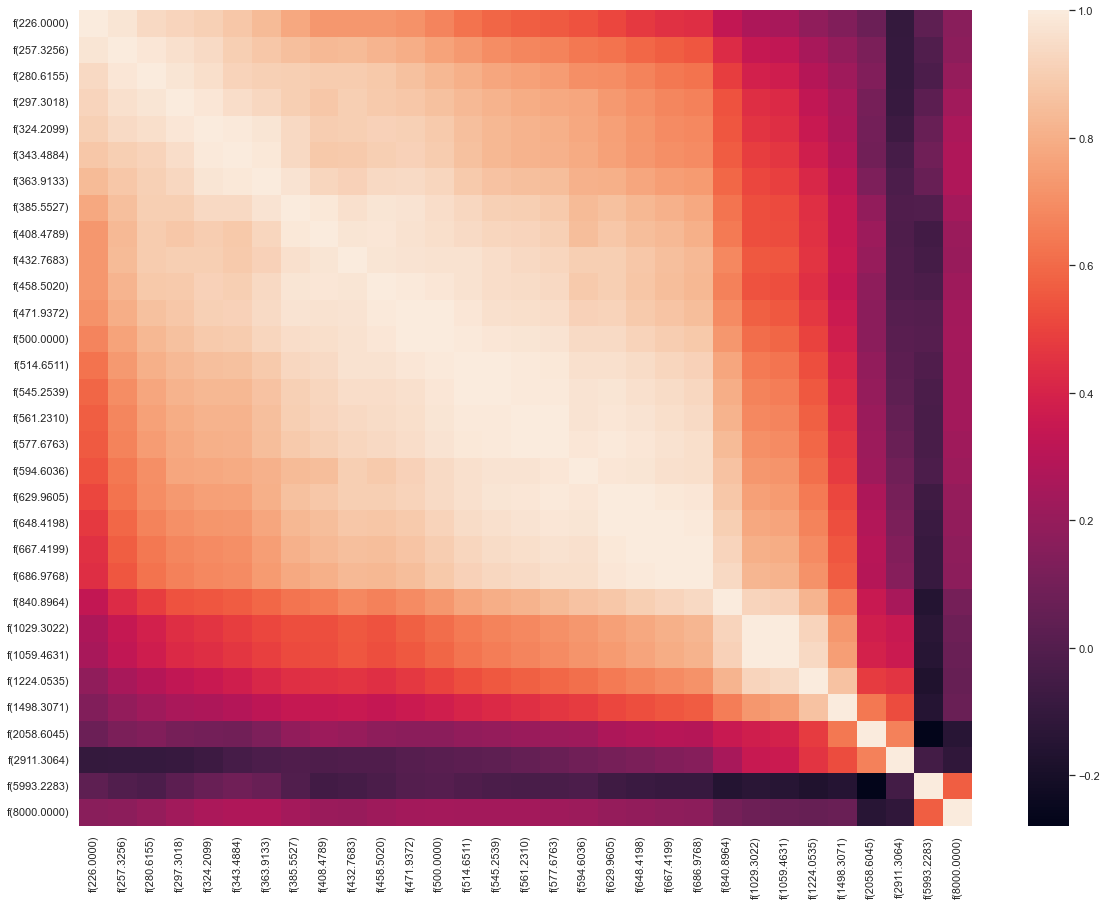

In [275]:
assess_corrs(wba_data, freqs_ffs)

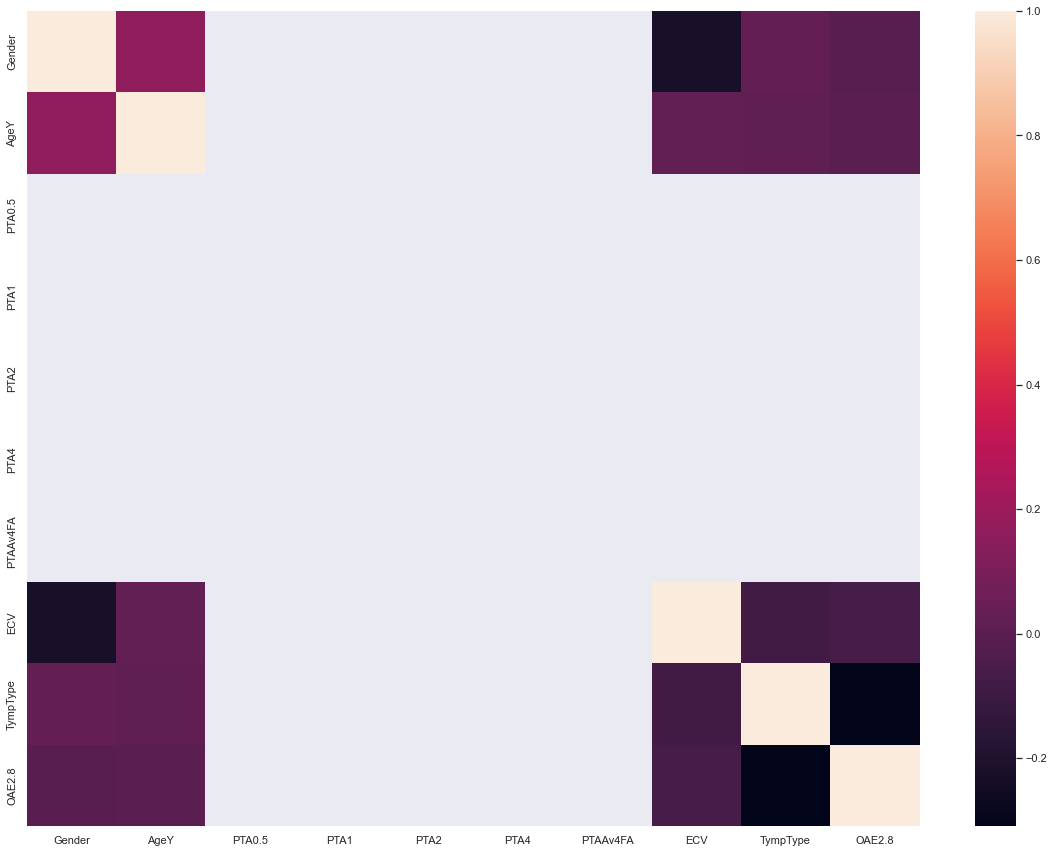

In [277]:
assess_corrs(wba_data, conts_ffs)

### Backward Feature Elimination

As we want a smaller number of variables, BFS is not the best option. Furthermore, the script is prone to crashing using this.

In [16]:
# from mlxtend.feature_selection import SequentialFeatureSelector
# from sklearn.linear_model import LogisticRegression

# lr = LogisticRegression(
#     class_weight = "balanced",
#     solver = "lbfgs",
#     random_state=42,
#     n_jobs = -1
# )

# bfs = SequentialFeatureSelector(lr, k_features = 'best', forward = False, n_jobs = -1)
# bfs.fit(X, y)

In [234]:
# features_bfs = list(bfs.k_feature_names_)
# freqs_bfs = [f for f in features_bfs if f[:2] == "f("]

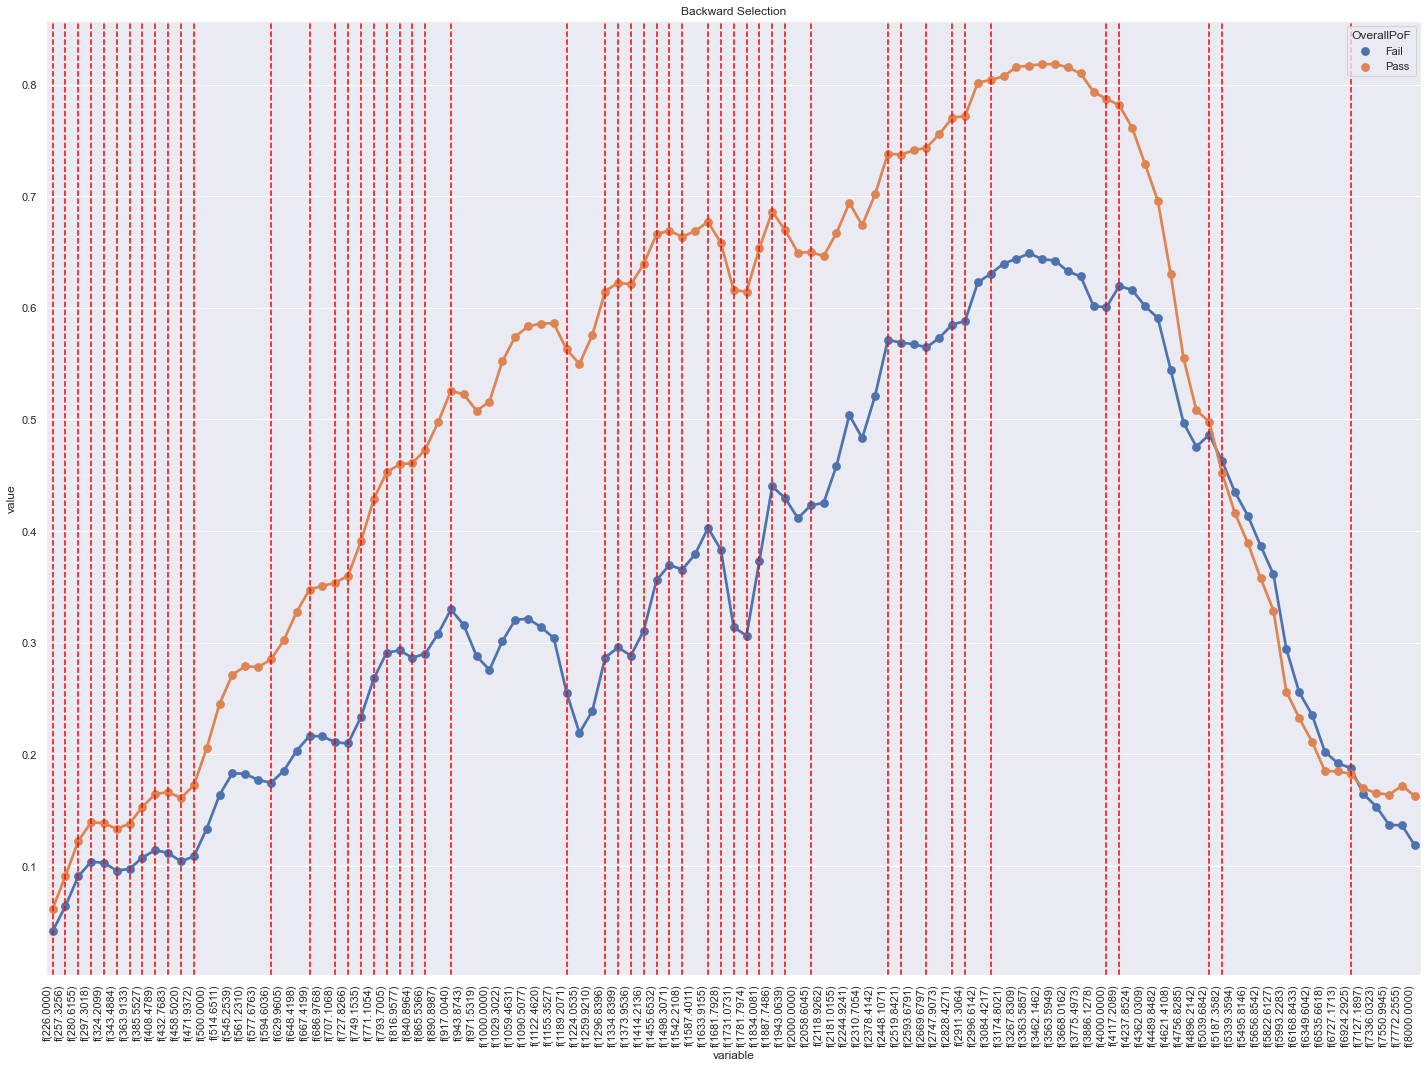

In [198]:
# assess_freqs(wba_data, freqs, features_bfs, title="Backward Selection")

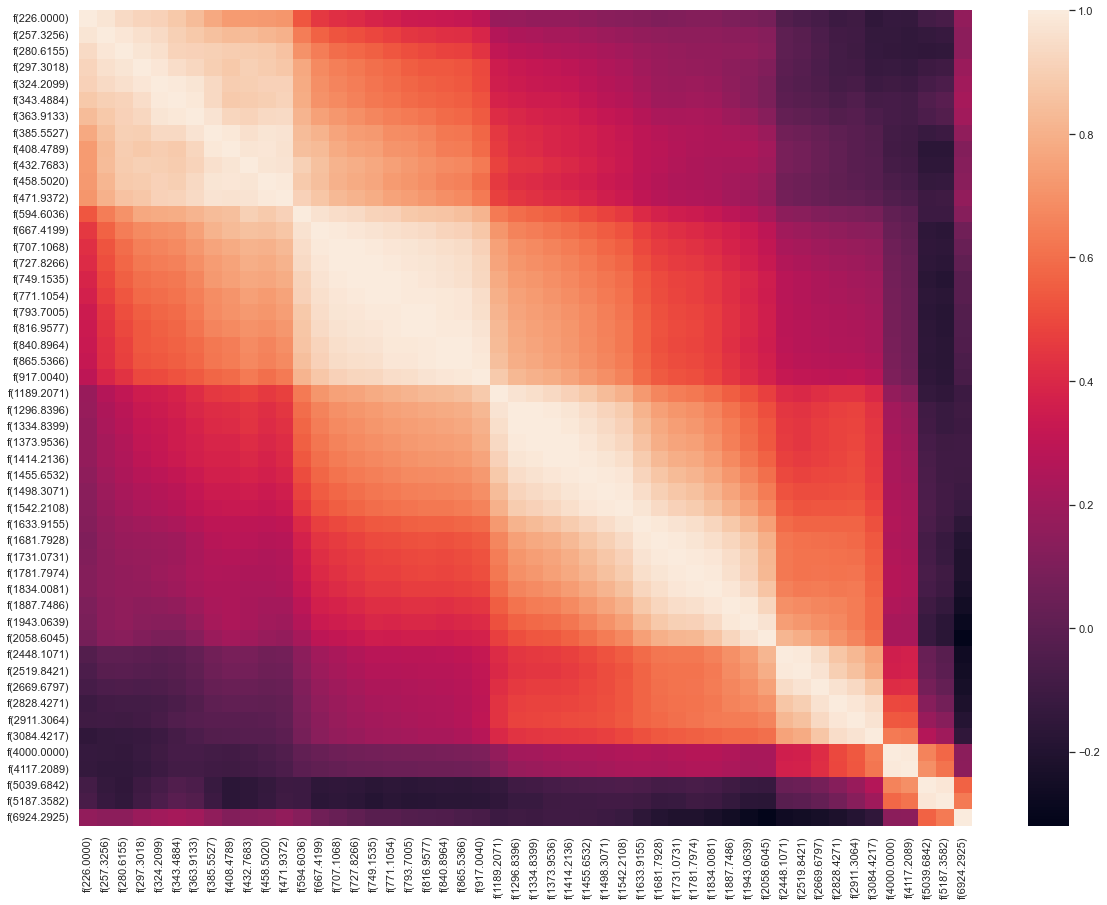

In [199]:
# assess_corrs(wba_data, features_bfs)

### Exhaustive Selection

Brute-force method: Tries every possible combination of variables and returns the best-performing subset. (LONG RUNTIME)

In [ ]:
# from mlxtend.feature_selection import ExhaustiveFeatureSelector

# # Algorithm to test features on
# efs = ExhaustiveFeatureSelector(lr,
#     min_features = 6,
#     max_features = 24,
#     scoring = 'roc_auc',
#     cv=2
#     )

# # Fit object to data
# efs = efs.fit(X, y)

# # Print selected features
# features_efs = X.columns[list(efs.best_idx_)]
# print(features_efs)

### Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=15, step=10, verbose=5)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()

In [20]:
features_rfe = X.loc[:,rfe_support].columns.tolist()
print(str(len(features_rfe)), 'selected features')

conts_rfe, freqs_rfe = assess_feats(features_rfe)

15 selected features
Selected control variables:
['AgeY', 'ECV', 'TympType']
Selected frequencies:
['f(1155.3527)', 'f(1189.2071)', 'f(1224.0535)', 'f(1259.9210)', 'f(1414.2136)', 'f(1455.6532)', 'f(1498.3071)', 'f(1542.2108)', 'f(1587.4011)', 'f(1633.9155)', 'f(1781.7974)', 'f(8000.0000)']


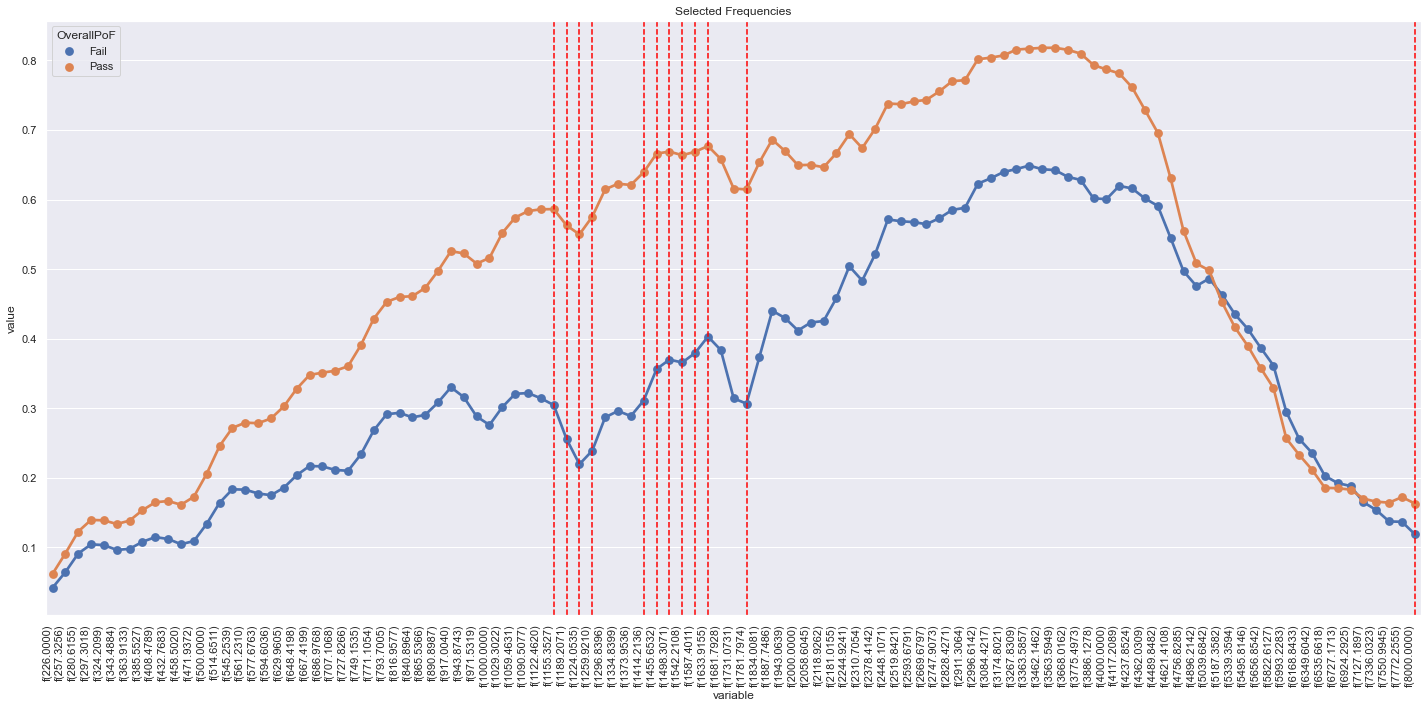

In [22]:
assess_freqs(wba_data, freqs, freqs_rfe)

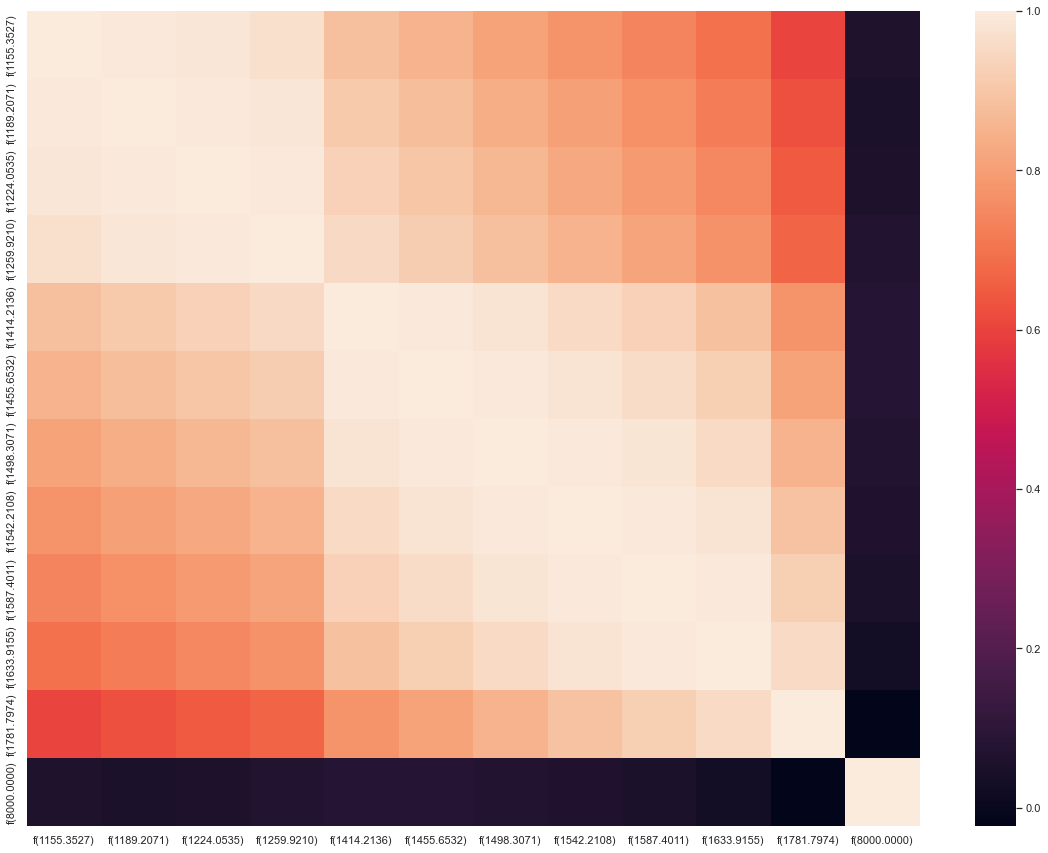

In [25]:
assess_corrs(wba_data, freqs_rfe)

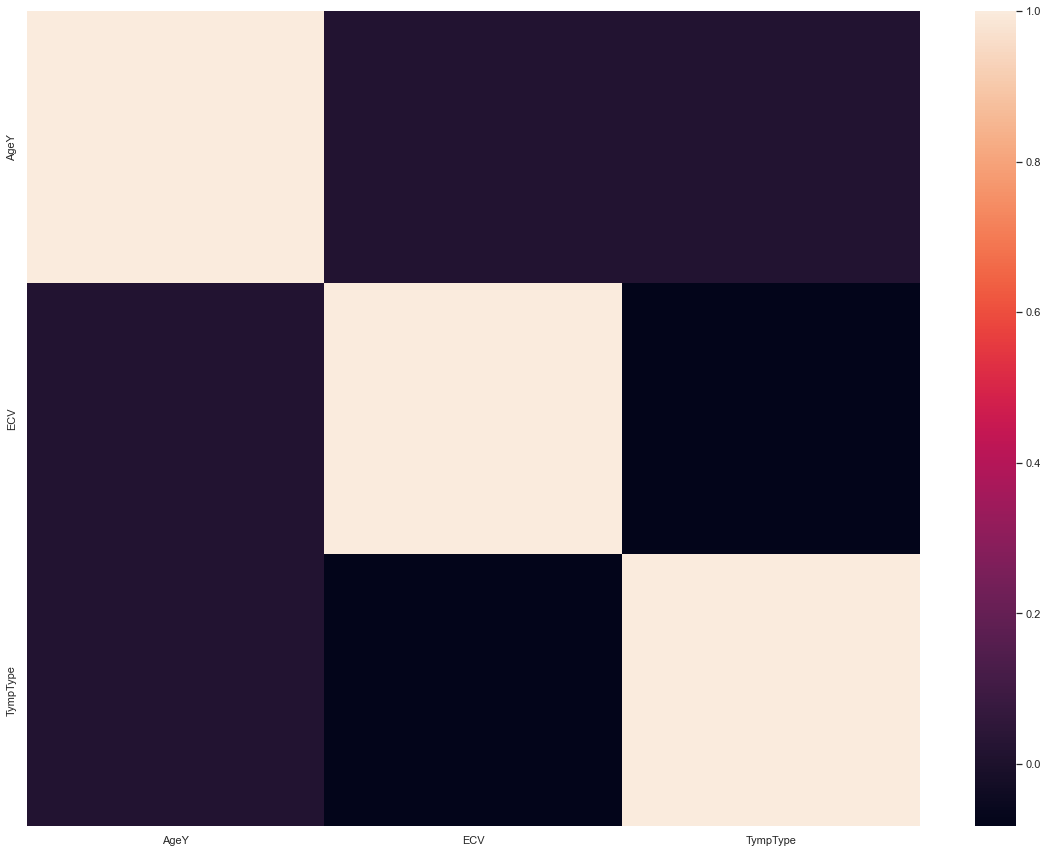

In [24]:
assess_corrs(wba_data, conts_rfe)

## Random Forest

In [223]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=420),max_features=55)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
features_rf = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(features_rf)), 'selected features')

SelectFromModel(estimator=RandomForestClassifier(n_estimators=420),
                max_features=55)

24 selected features


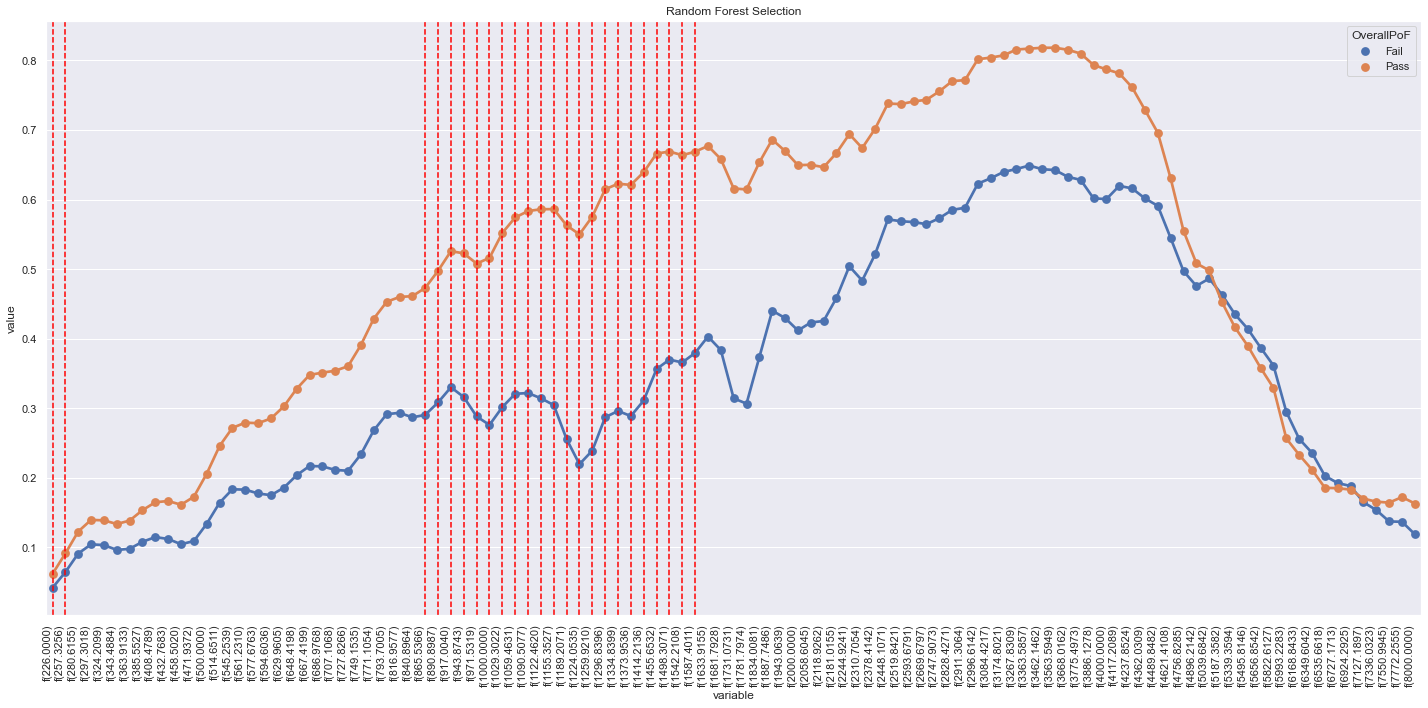

In [224]:
assess_freqs(wba_data, freqs, features_rf, title="Random Forest Selection")